## Import

In [34]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from keras.losses import CategoricalCrossentropy
from keras import activations
from sklearn.metrics import confusion_matrix
from utils.df_utils import df_wrapper
from utils.declarations import training_files, testing_files, POSE_MAP

## Define data

In [35]:
AMOUNT_OF_SENSORS = 3
VALIDATION_TESTSET = "004"

## Datapreparation

### Train

In [36]:
x_train_arr = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(training_files[key].annot_file, POSE_MAP)
    x_train_arr.append(elem)

x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in x_train_arr])
y_train = pd.concat([x.df['Pose'] for x in x_train_arr])

..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

### Test

In [37]:
x_test_dict = dict()
y_test_dict = dict()
for key in testing_files:
    elem = df_wrapper(testing_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(testing_files[key].annot_file, POSE_MAP)
    y_test = elem.df["Pose"]
    y_test.index = [i for i in range(len(y_test))]
    x_test_dict[key] = elem.df
    y_test_dict[key] = y_test

x_test = x_test_dict[VALIDATION_TESTSET].drop([' TimeStamp (s)', 'Pose'], axis=1) 
y_test = y_test_dict[VALIDATION_TESTSET]

..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

## Visualisation

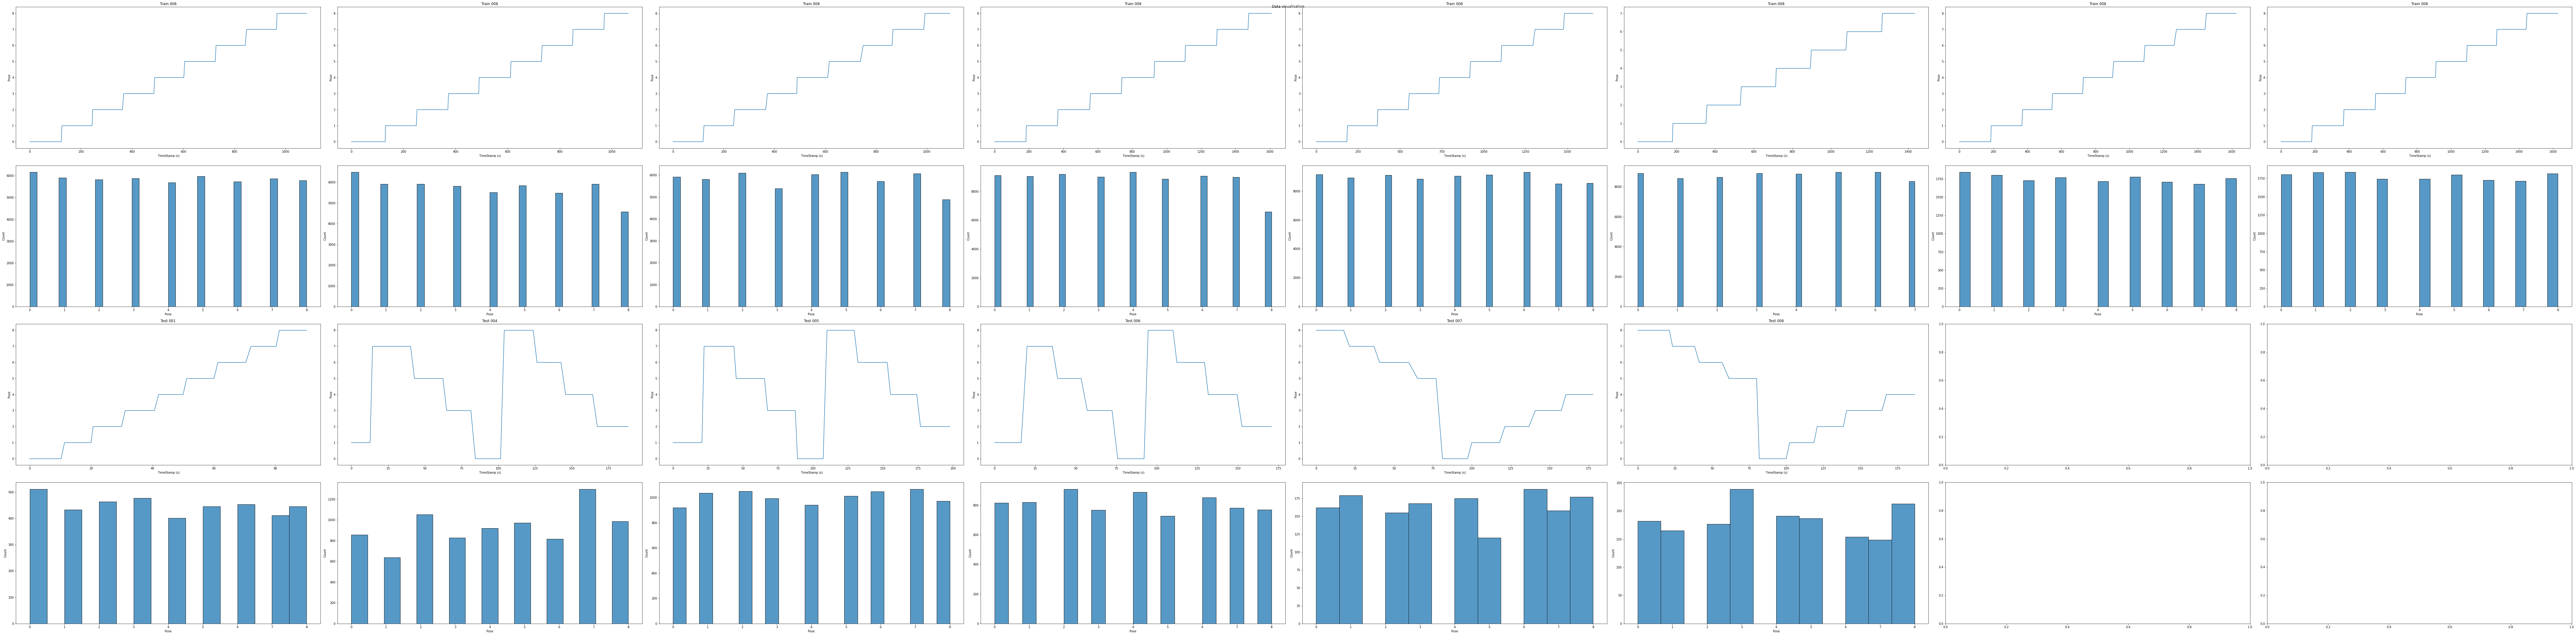

In [38]:
cols = []
height=30
width=(height/2)*len(x_train_arr)
fig, axes = plt.subplots(4, len(x_train_arr), figsize=(width, height))
fig.suptitle('Data visualisation')
# Train
for i, elem in enumerate(x_train_arr):
    sns.lineplot(ax=axes[0, i], data=elem.df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=elem.df["Pose"])
    cols.append(f'Train {key}')     
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
# Test
cols=[]
for i, key in enumerate(x_test_dict):
    sns.lineplot(ax=axes[2, i], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[3, i], data=y_test_dict[key])
    cols.append(f'Test {key}') 
for ax, col in zip(axes[2], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Adjust dataframes

In [39]:
# Create numpy arrays
x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values

# Hot encode categories into numbers
y_train = to_categorical(y_train_numpy,9)
y_test = to_categorical(y_test_numpy,9)

In [40]:
print(np.shape(x_train_numpy))

(418127, 39)


## Hyperparams

In [41]:
from sklearn.preprocessing import StandardScaler


In [49]:

OPTIM = Adam(learning_rate=0.00001)
# OPTIM = RMSPROP(learning_rate=LR)

# Shapes
INPUT_SHAPE = x_train_numpy.shape[1]
OUTPUT_SHAPE = 9
HIDDEN_SHAPE = int((INPUT_SHAPE + OUTPUT_SHAPE) / 2)

## Model

In [50]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(INPUT_SHAPE,)))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(9, activation='softmax'))
model.summary()
model.compile(optimizer=OPTIM, loss=CategoricalCrossentropy(), metrics=['accuracy'])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               5120      
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)               

## Fit the model

In [51]:
history = model.fit(x=x_train_numpy, y=y_train, batch_size=64, epochs=20, validation_data=(x_test_numpy, y_test))

Epoch 1/20
6534/6534 [==============================] - 29s 4ms/step - loss: 7.0740 - accuracy: 0.1181 - val_loss: 2.0638 - val_accuracy: 0.2106
Epoch 2/20
6534/6534 [==============================] - 28s 4ms/step - loss: 2.1956 - accuracy: 0.1831 - val_loss: 1.7411 - val_accuracy: 0.5166
Epoch 3/20
6534/6534 [==============================] - 28s 4ms/step - loss: 1.8013 - accuracy: 0.2862 - val_loss: 1.4822 - val_accuracy: 0.3234
Epoch 4/20
6534/6534 [==============================] - 20s 3ms/step - loss: 1.4884 - accuracy: 0.4001 - val_loss: 1.2938 - val_accuracy: 0.3238
Epoch 5/20
6534/6534 [==============================] - 16s 2ms/step - loss: 1.2360 - accuracy: 0.4999 - val_loss: 1.1523 - val_accuracy: 0.4012
Epoch 6/20
6534/6534 [==============================] - 14s 2ms/step - loss: 1.0390 - accuracy: 0.5804 - val_loss: 1.0053 - val_accuracy: 0.5137
Epoch 7/20
6534/6534 [==============================] - 24s 4ms/step - loss: 0.8706 - accuracy: 0.6521 - val_loss: 0.8671 - val_ac

## Visualise the loss

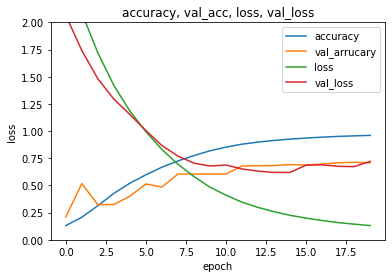

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot()
plt.title('accuracy, val_acc, loss, val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_arrucary', 'loss', 'val_loss'], loc='upper right')

axes=plt.gca()
axes.set_ylim(0,2)
plt.show()

## Precision

In [53]:
print("Classification accuracy:")
classification_dict = dict()

for key in x_test_dict:
    x_test = x_test_dict[key].drop([' TimeStamp (s)', 'Pose'], axis=1)
    classify = model.predict(x_test)
    classifications = [i.argmax() for i in classify]
    annotated_positions = y_test_dict[key].to_numpy()
    correct_classifications = (classifications == annotated_positions).sum()
    
    print(f"{key}: {round(correct_classifications/len(classifications)*100,2)}%")
    classification_dict[key] = classifications

Classification accuracy:
001: 34.14%
004: 70.78%
005: 84.63%
006: 88.28%
007: 76.99%
008: 37.78%


## Visualise classification

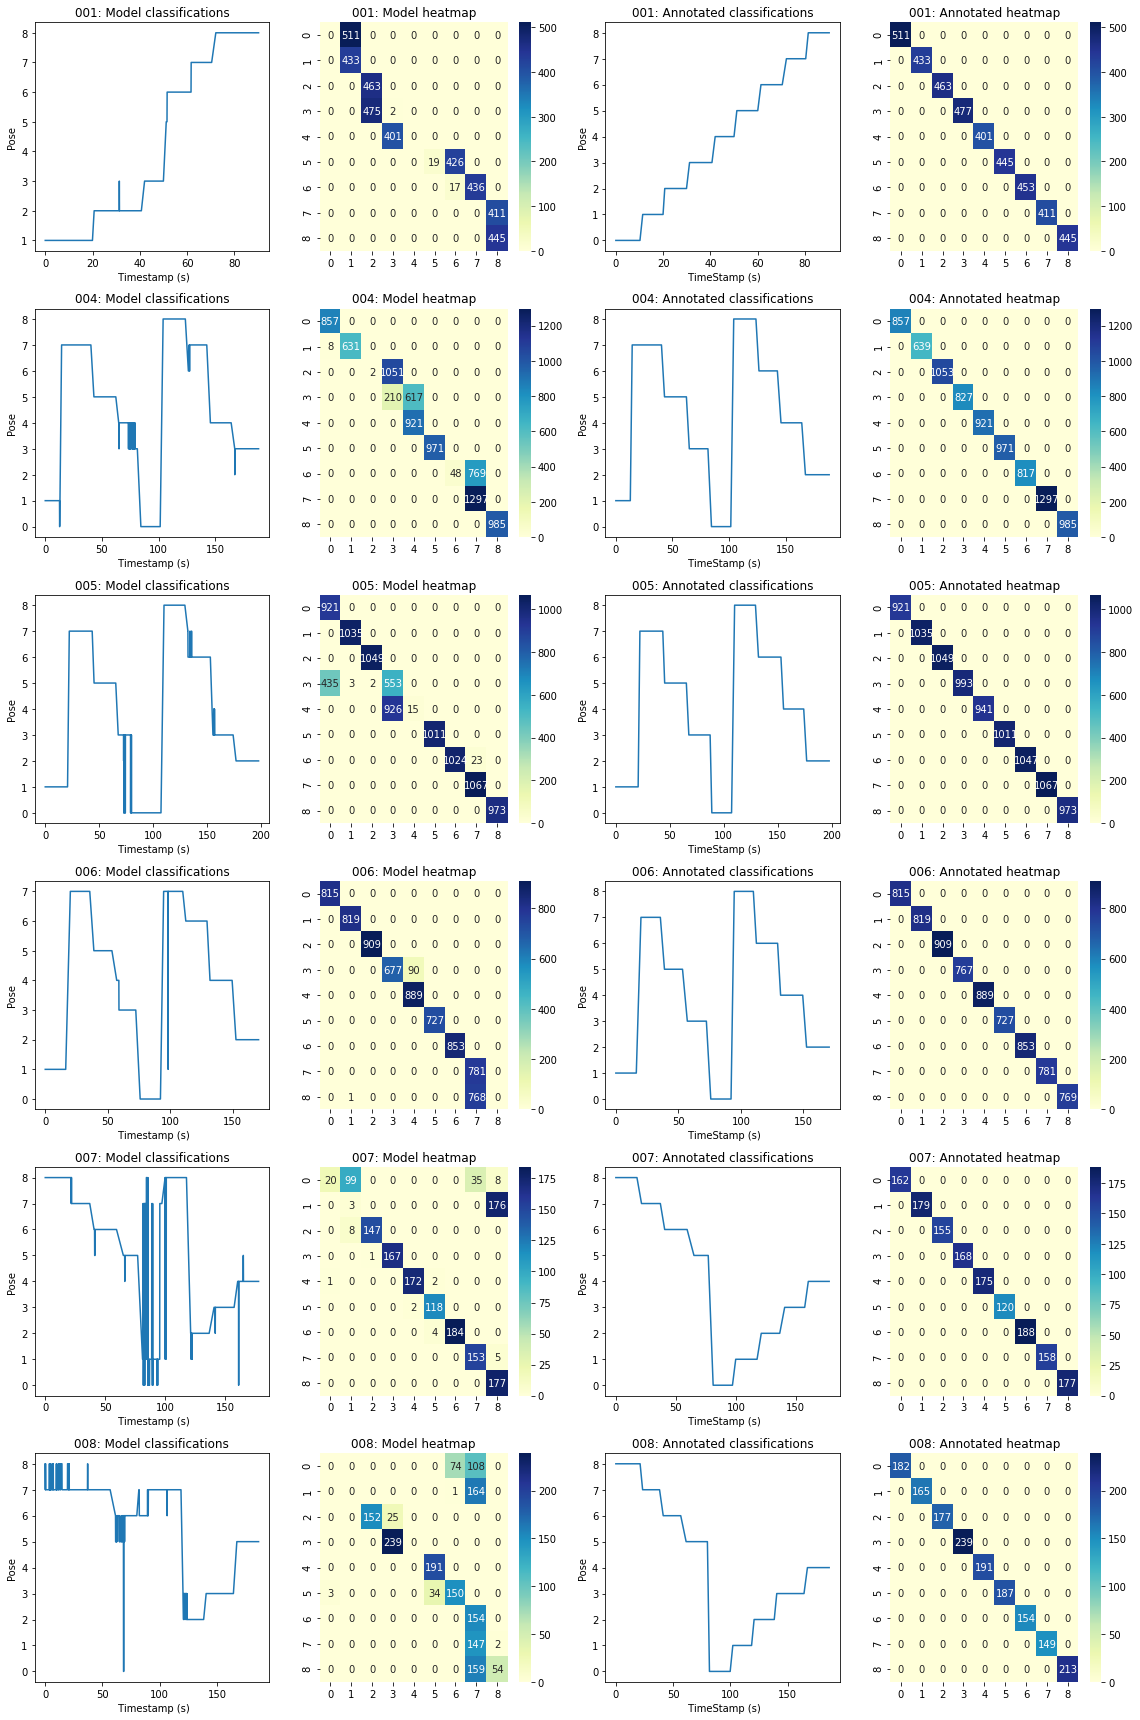

In [54]:
width=16
height=4*len(x_test_dict)
fig, axes = plt.subplots(len(x_test_dict), 4, figsize=(width, height))
for i, key in enumerate(x_test_dict):
    cols = [f"{key}: Model classifications", f"{key}: Model heatmap", f"{key}: Annotated classifications", f"{key}: Annotated heatmap"]
    df_predict = pd.DataFrame({' Timestamp (s)': x_test_dict[key][' TimeStamp (s)'],'Pose':classification_dict[key]})
    sns.lineplot(ax=axes[i, 0], data=df_predict,x=' Timestamp (s)',y='Pose')
    sns.heatmap(ax=axes[i, 1], data=confusion_matrix(y_test_dict[key], classification_dict[key]), cmap="YlGnBu", annot=True, fmt="d")
    sns.lineplot(ax=axes[i, 2], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.heatmap(ax=axes[i, 3], data=confusion_matrix(y_test_dict[key], y_test_dict[key].to_numpy()), cmap="YlGnBu", annot=True, fmt="d")
    for ax, col in zip(axes[i], cols): ax.set_title(col)
fig.tight_layout()
plt.show()

In [55]:

#path = f"../models/ANN_model_{AMOUNT_OF_SENSORS}_130421.h5"
#model.save(path)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>